<a href="https://colab.research.google.com/github/kpsalida/HospitalDischarges_Visualization/blob/Katerina/viz_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Dataset acquisition

The analysis utilizes the 2019 Hospital Inpatient Discharges (SPARCS De-Identified) dataset, publicly available through the New York State Open Data Portal (https://health.data.ny.gov/Health/Hospital-Inpatient-Discharges-SPARCS-De-Identified/4ny4-j5zv).  

SPARCS (Statewide Planning and Research Cooperative System) is a comprehensive administrative database that captures patient-level inpatient discharge records across New York State. The dataset includes clinical, operational, and financial variables such as length of stay (LOS), total charges, payer type, severity of illness, risk of mortality, and facility identifiers.

The dataset was restricted to discharges occurring in calendar year 2019 to avoid analysis inconsistencies arising from COVID-19 pandemic. Additionally it was narrowd to 3 Hospitals  Furthermore, the scope of the study was narrowed to  allow comparisons cross - facilities but also to maintain computational efficiency within the PowerBI environment. Two of the hospitals are major institutions in NYC while the third is more regional with a possibility of different LOS patterns and a different cost structure

With this filtering we are hoping for a more standardized performance comparison using normalized key performance indicators (KPIs), such as average LOS and average charges per discharge, independent of hospital size.

- Maimonides Medical Center : Large Establishment in NYC
- NewYork-Presbyterian / Hudson Valley Hospital : Strong comparison to Maimonidies
- St. Joseph's Medical Center : Regional LOS and cost structure
#  
Each row in the dataset does not represent one patient but rather one discharge. So, we are analyzing discharges and this could occur to the same patient.  
#
Differences in discharge volume across hospitals were addressed using normalized performance metrics to ensure comparability.

# Import Libraries

In [271]:
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
from google.colab import drive
#
# Set pandas display option to show up to 100 columns when printing a DataFrame
pd.set_option('display.max_columns', 100)


In [188]:
df.columns

Index(['Hospital Service Area', 'Hospital County',
       'Operating Certificate Number', 'Permanent Facility Id',
       'Facility Name', 'Age Group', 'Zip Code - 3 digits', 'Gender', 'Race',
       'Ethnicity', 'Length of Stay', 'Type of Admission',
       'Patient Disposition', 'Discharge Year', 'CCSR Diagnosis Code',
       'CCSR Diagnosis Description', 'CCSR Procedure Code',
       'CCSR Procedure Description', 'APR DRG Code', 'APR DRG Description',
       'APR MDC Code', 'APR MDC Description', 'APR Severity of Illness Code',
       'APR Severity of Illness Description', 'APR Risk of Mortality',
       'APR Medical Surgical Description', 'Payment Typology 1',
       'Payment Typology 2', 'Payment Typology 3', 'Birth Weight',
       'Emergency Department Indicator', 'Total Charges', 'Total Costs'],
      dtype='object')

# Explanation of Data Fields

**Hospital County**
Type is Char. Length is 11. A description of the county in which the hospital is located. Blank for records with enhanced de-identification.  
#  
**Facility Name**
Type is Char. Length is 112. The name of the facility where services were performed based on the Permanent Facility Identifier (PFI), as maintained by the NYSDOH Division of Health Facility Planning. For records with enhanced de-identification, ‘Redacted for Confidentiality’ appears.  

**Age Group**
Type is Char. Length is 11. Age in years at time of discharge. Grouped into the following age groups: 0 to 17, 18 to 29, 30 to 49, 50 to 69, and 70 or Older  

**Gender**
Type is Char. Length is 1. Patient gender: (M) Male, (F) Female, (U) Unknown.  

**Race**
Type is Char. Length is 32. Patient race. Black/African American, Multi-racial, Other Race, White. Other Race includes Native Americans and Asian/Pacific Islander.  

**Ethnicity**
Type is Char. Length is 20. Patient ethnicity. The ethnicity of the patient: Spanish/Hispanic Origin, Not of Spanish/Hispanic Origin, Multi-ethnic Unknown.  

**Length of Stay**
Type is Char. Length is 5. The total number of patient days at an acute level and/or other than acute care level (excluding leave of absence days) (Discharge Date - Admission Date) + 1. Length of Stay greater than or equal to 120 days has been aggregated to 120+ days  

**Type of Admission**
Type is Char. Length is 15. A description of the manner in which the patient was admitted to the health care facility: Elective, Emergency, Newborn, Not Available, Trauma, Urgent   

**Patient Disposition**
Type is Char. Length is 37. The patient's destination or status upon discharge  

**APR DRG Description ??**
Type is Char. Length is 500. The APR-DRG Classification Code Description in Calendar Year 2019, Version 36 of the APR- DRG Grouper. http://www.health.ny.gov/statistics/sparcs/sysdoc/appy.htm  
#
**APR Severity of Illness Description**
Type is Char. Length is 8. All Patient Refined Severity of Illness (APR SOI) Description: Undetermined (0), Minor (1), Moderate (2), Major (3), Extreme (4)  

**APR Risk of Mortality**
Type is Char. Length is 8. All Patient Refined Risk of Mortality (APR ROM) Description: Undetermined (0), Minor (1), Moderate (2), Major (3), Extreme (4).  
#
**Payment Typology 1**
Type is Char. Length is 25. A description of the type of payment for this occurrence.  

**Emergency Department Indicator**
Type is Char. Length is 1. The Emergency Department Indicator is set based on the submitted revenue codes. If the record contained an Emergency Department revenue code of 045X, the indicator is set to "Y", otherwise it will be “N”.  

**Total Charges**
Type is Char. Length is 8. Total charges for the discharge.  
#
**Total Costs**
Type is Char. Length is 8. Total estimated cost for the discharge.


# Column Selection

We excluded deep medical analysis with CCSR terms
All ids that might be confusing.  
Discharge year as our dataset is related only to 2019  
#
We selected the following features according to business logic:
#

**Identification**  
Hospital County  
Facility Name  

**Demographics**  
Age Group  
Gender  
Race / Ethnicity (only if you want social analysis — otherwise skip)    
  
**OPERATIONS**  
Length of Stay (IMPORTANT → convert to numeric)  
Type of Admission  
Emergency Department Indicator  
'Patient Disposition'
  
**FINANCIAL**  
Total Charges (convert to numeric)  
Total Costs (convert to numeric)  

**CLINICAL COMPLEXITY**  
APR Severity of Illness Description

APR Risk of Mortality

APR DRG Description      

**PAYER**

Payment Typology 1 (KEEP ONLY THIS)


# **About Low Variance Features**

# Mount Google Drive to access files.

In [228]:
# Mounts the drive; if already mounted, it just continues
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [229]:
#Jump directly into your specific project folder
%cd /content/drive/MyDrive/Colab Notebooks/FinalProject_Visualization

/content/drive/MyDrive/Colab Notebooks/FinalProject_Visualization


In [230]:
df = pd.read_csv('raw_hospital_discharges_2019.csv', low_memory = False)

# Retrospective Duplication Test

In [231]:
# Keep will
dup_groups = df[df.duplicated(keep=False)]
n_groups = dup_groups.groupby(list(df.columns)).ngroups
n_groups

117

In [232]:
dups_all = df.duplicated(keep=False)
df_dups_all = df[dups_all].sort_values(by=df.columns.tolist())
df_dups_all.shape[0]

1426

# 1st - Initial Identification of the dataframe.  


In [233]:
df.head()

,Hospital Service Area,Hospital County,Operating Certificate Number,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,Length of Stay,Type of Admission,Patient Disposition,Discharge Year,CCSR Diagnosis Code,CCSR Diagnosis Description,CCSR Procedure Code,CCSR Procedure Description,APR DRG Code,APR DRG Description,APR MDC Code,APR MDC Description,APR Severity of Illness Code,APR Severity of Illness Description,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Birth Weight,Emergency Department Indicator,Total Charges,Total Costs
0,New York City,Kings,7001020,1305,Maimonides Medical Center,50 to 69,112,F,Other Race,Not Span/Hispanic,21,Urgent,Skilled Nursing Home,2019,INJ033,"COMPLICATION OF CARDIOVASCULAR DEVICE, IMPLANT...",CAR022,HEART VALVE REPLACEMENT AND OTHER VALVE PROCED...,162.0,CARDIAC VALVE PROCEDURES W AMI OR COMPLEX PDX,5.0,DISEASES AND DISORDERS OF THE CIRCULATORY SYSTEM,4.0,Extreme,Extreme,Surgical,Medicaid,Medicaid,Self-Pay,NaN,False,"$401,807.05","$100,294.11"
1,New York City,Kings,7001020,1305,Maimonides Medical Center,0 to 17,112,F,Black/African American,Not Span/Hispanic,3,Emergency,Home or Self Care,2019,RSP009,ASTHMA,ESA004,NON-INVASIVE VENTILATION,141.0,ASTHMA,4.0,DISEASES AND DISORDERS OF THE RESPIRATORY SYSTEM,3.0,Major,Moderate,Medical,Medicaid,Medicaid,Self-Pay,NaN,True,"$46,725.01","$23,058.16"
2,New York City,Kings,7001020,1305,Maimonides Medical Center,0 to 17,112,F,White,Unknown,1,Newborn,Home or Self Care,2019,PNL001,LIVEBORN,NaN,NaN,640.0,"NEONATE BIRTHWT >2499G, NORMAL NEWBORN OR NEON...",15.0,NEWBORNS AND OTHER NEONATES WITH CONDITIONS OR...,1.0,Minor,Minor,Medical,Medicaid,Medicaid,Self-Pay,04100,False,"$3,393",$490.45
3,New York City,Kings,7001020,1305,Maimonides Medical Center,18 to 29,112,F,White,Unknown,2,Urgent,Home or Self Care,2019,PRG023,COMPLICATIONS SPECIFIED DURING CHILDBIRTH,PGN002,SPONTANEOUS VAGINAL DELIVERY,560.0,VAGINAL DELIVERY,14.0,"PREGNANCY, CHILDBIRTH AND THE PUERPERIUM",1.0,Minor,Minor,Medical,Medicaid,Medicaid,Self-Pay,NaN,True,"$20,858.02","$5,445.28"
4,New York City,Kings,7001020,1305,Maimonides Medical Center,18 to 29,116,F,White,Not Span/Hispanic,2,Urgent,Home or Self Care,2019,PRG029,"UNCOMPLICATED PREGNANCY, DELIVERY OR PUERPERIUM",PGN004,ASSISTED VAGINAL DELIVERY,560.0,VAGINAL DELIVERY,14.0,"PREGNANCY, CHILDBIRTH AND THE PUERPERIUM",1.0,Minor,Minor,Medical,Medicaid,Medicaid,Self-Pay,NaN,False,"$21,116.01","$5,295.36"


In [234]:
print("Number of Rows:", df.shape[0])
print("Number of Columns:", df.shape[1])

Number of Rows: 53390
Number of Columns: 33


In [196]:
df.columns

Index(['Hospital Service Area', 'Hospital County',
       'Operating Certificate Number', 'Permanent Facility Id',
       'Facility Name', 'Age Group', 'Zip Code - 3 digits', 'Gender', 'Race',
       'Ethnicity', 'Length of Stay', 'Type of Admission',
       'Patient Disposition', 'Discharge Year', 'CCSR Diagnosis Code',
       'CCSR Diagnosis Description', 'CCSR Procedure Code',
       'CCSR Procedure Description', 'APR DRG Code', 'APR DRG Description',
       'APR MDC Code', 'APR MDC Description', 'APR Severity of Illness Code',
       'APR Severity of Illness Description', 'APR Risk of Mortality',
       'APR Medical Surgical Description', 'Payment Typology 1',
       'Payment Typology 2', 'Payment Typology 3', 'Birth Weight',
       'Emergency Department Indicator', 'Total Charges', 'Total Costs'],
      dtype='object')

In [235]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Operating Certificate Number,53390.0,6.748851e+06,461858.850345,5901000.0,7001020.0,7001020.0,7001020.0,7001020.0
Permanent Facility Id,53390.0,1.248337e+03,104.624142,1039.0,1305.0,1305.0,1305.0,1305.0
Discharge Year,53390.0,2.019000e+03,0.000000,2019.0,2019.0,2019.0,2019.0,2019.0
APR DRG Code,53377.0,4.372920e+02,229.146079,4.0,204.0,469.0,640.0,956.0
APR MDC Code,53377.0,1.082491e+01,5.516998,0.0,5.0,11.0,15.0,25.0
APR Severity of Illness Code,53377.0,2.036214e+00,1.006992,0.0,1.0,2.0,3.0,4.0


In [236]:
df.value_counts('APR DRG Description',dropna=False)

,count
APR DRG Description,
"NEONATE BIRTHWT >2499G, NORMAL NEWBORN OR NEONATE W OTHER PROBLEM",7555
VAGINAL DELIVERY,6066
SEPTICEMIA & DISSEMINATED INFECTIONS,3204
CESAREAN DELIVERY,2071
HEART FAILURE,1595
...,...
UNGROUPABLE,1
GASTRIC FUNDOPLICATION,1
CRANIOTOMY FOR MULTIPLE SIGNIFICANT TRAUMA,1


In [237]:
df.value_counts('Facility Name',dropna=False)

,count
Facility Name,
Maimonides Medical Center,41129
NewYork-Presbyterian/Hudson Valley Hospital,8258
St. Joseph's Medical Center,4003


In [238]:
df.value_counts('Permanent Facility Id',dropna=False)

,count
Permanent Facility Id,
1305,41129
1039,8258
1098,4003


In [239]:
df.value_counts('Payment Typology 3', dropna=False)

,count
Payment Typology 3,
Self-Pay,28722
NaN,20260
Medicaid,3977
Private Health Insurance,241
Blue Cross/Blue Shield,113
Medicare,49
Federal/State/Local/VA,28


In [240]:
df.value_counts('Type of Admission', dropna=False)

,count
Type of Admission,
Emergency,32419
Urgent,9117
Newborn,8338
Elective,3508
Not Available,8


In [241]:
df.value_counts('Emergency Department Indicator',dropna=False)

,count
Emergency Department Indicator,
True,30744
False,22646


In [204]:
df.value_counts('Patient Disposition',dropna=False)

,count
Patient Disposition,
Home or Self Care,36907
Skilled Nursing Home,6696
Home w/ Home Health Services,5831
Expired,1258
Left Against Medical Advice,944
Short-term Hospital,748
Inpatient Rehabilitation Facility,308
Hospice - Home,205
Hospice - Medical Facility,173


# Keep only selected columns

In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53390 entries, 0 to 53389
Data columns (total 33 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Hospital Service Area                53390 non-null  object 
 1   Hospital County                      53390 non-null  object 
 2   Operating Certificate Number         53390 non-null  int64  
 3   Permanent Facility Id                53390 non-null  int64  
 4   Facility Name                        53390 non-null  object 
 5   Age Group                            53390 non-null  object 
 6   Zip Code - 3 digits                  52821 non-null  object 
 7   Gender                               53390 non-null  object 
 8   Race                                 53390 non-null  object 
 9   Ethnicity                            53390 non-null  object 
 10  Length of Stay                       53390 non-null  object 
 11  Type of Admission           

In [242]:

# columns to KEEP

columns_to_keep = [
    "Hospital County",
    "Facility Name",
    "Age Group",
    "Gender",
    "Race",
    "Ethnicity",
    "Length of Stay",
    "Type of Admission",
    "Patient Disposition",
    "APR DRG Description",
    "APR Severity of Illness Description",
    "APR Risk of Mortality",
    "Payment Typology 1",
    "Emergency Department Indicator",
    "Total Charges",
    "Total Costs"
]

df1 = df.copy()
df = df[columns_to_keep]

# Overview and Structure of my dataframe

In [243]:
df.head()

,Hospital County,Facility Name,Age Group,Gender,Race,Ethnicity,Length of Stay,Type of Admission,Patient Disposition,APR DRG Description,APR Severity of Illness Description,APR Risk of Mortality,Payment Typology 1,Emergency Department Indicator,Total Charges,Total Costs
0,Kings,Maimonides Medical Center,50 to 69,F,Other Race,Not Span/Hispanic,21,Urgent,Skilled Nursing Home,CARDIAC VALVE PROCEDURES W AMI OR COMPLEX PDX,Extreme,Extreme,Medicaid,False,"$401,807.05","$100,294.11"
1,Kings,Maimonides Medical Center,0 to 17,F,Black/African American,Not Span/Hispanic,3,Emergency,Home or Self Care,ASTHMA,Major,Moderate,Medicaid,True,"$46,725.01","$23,058.16"
2,Kings,Maimonides Medical Center,0 to 17,F,White,Unknown,1,Newborn,Home or Self Care,"NEONATE BIRTHWT >2499G, NORMAL NEWBORN OR NEON...",Minor,Minor,Medicaid,False,"$3,393",$490.45
3,Kings,Maimonides Medical Center,18 to 29,F,White,Unknown,2,Urgent,Home or Self Care,VAGINAL DELIVERY,Minor,Minor,Medicaid,True,"$20,858.02","$5,445.28"
4,Kings,Maimonides Medical Center,18 to 29,F,White,Not Span/Hispanic,2,Urgent,Home or Self Care,VAGINAL DELIVERY,Minor,Minor,Medicaid,False,"$21,116.01","$5,295.36"


In [244]:
print("Number of Rows:", df.shape[0])
print("Number of Columns:", df.shape[1])

Number of Rows: 53390
Number of Columns: 16


In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53390 entries, 0 to 53389
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Hospital County                      53390 non-null  object
 1   Facility Name                        53390 non-null  object
 2   Age Group                            53390 non-null  object
 3   Gender                               53390 non-null  object
 4   Race                                 53390 non-null  object
 5   Ethnicity                            53390 non-null  object
 6   Length of Stay                       53390 non-null  object
 7   Type of Admission                    53390 non-null  object
 8   Patient Disposition                  53390 non-null  object
 9   APR DRG Description                  53377 non-null  object
 10  APR Severity of Illness Description  53376 non-null  object
 11  APR Risk of Mortality                5337

## **Data Types**

In [246]:
# Convert Total Charges and Total Costs to numeric Fields
df["Total Charges"] = df["Total Charges"].str.replace("$", "", regex=False).str.replace(",", "", regex=False).astype(float)
df["Total Costs"] = df["Total Costs"].str.replace("$", "", regex=False).str.replace(",", "", regex=False).astype(float)


There is an issue with the LOS variable. For LOS > = 120, then they are bucketed into 120 + categorization making the column object. We are going to bucket these safely into 120. It is only 45 occurences.

In [250]:
(df["Length of Stay"] == "120 +").sum()

np.int64(45)

In [251]:
df['Length of Stay'] = df['Length of Stay'].replace('120 +', '120')

In [252]:
#Sanity Check
(df["Length of Stay"] == "120 +").sum()

np.int64(0)

In [255]:
(df["Length of Stay"] == "0").sum()

np.int64(0)

In [254]:

df["Length of Stay"] = pd.to_numeric(df["Length of Stay"])

## **Missing Values**

In [256]:
df.isna().sum()

,0
Hospital County,0
Facility Name,0
Age Group,0
Gender,0
Race,0
Ethnicity,0
Length of Stay,0
Type of Admission,0
Patient Disposition,0
APR DRG Description,13


In [257]:
#Find the percentage of missing overall in the dataframe
missing = df.isnull().sum().sum()
total_values = df.shape[0] * df.shape[1]

overall_missing_pct = (missing / total_values) * 100

print(f"Overall missing percentage: {overall_missing_pct:.4f}%")

Overall missing percentage: 0.0048%


Since the overall missing are 0.005%, then we can safely dropna


In [258]:
df.dropna(inplace=True)

In [259]:
#sanity check for nulls
df.isna().sum().sum()

np.int64(0)

## Identify Columns with low variance

In [260]:
counts = df.nunique()
check_cols_lowvariance = [i for i,v in enumerate(counts) if (float(v)/df.shape[0]*100) < 1]
check_cols_lowvariance

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

We cannot drop all these important columns. **The reason being that we do not care about low variance in our case.** Regarding Gender, or facility name . It is ok to have low variance.

In [261]:
counts

,0
Hospital County,2
Facility Name,3
Age Group,5
Gender,2
Race,4
Ethnicity,4
Length of Stay,109
Type of Admission,5
Patient Disposition,16
APR DRG Description,307


## Check Duplicate data


In [262]:
df.duplicated().sum()


np.int64(2631)

In [263]:
dup_groups = df[df.duplicated(keep=False)]
n_groups = dup_groups.groupby(list(df.columns)).ngroups
n_groups

633

In [264]:
dups_all = df.duplicated(keep=False)
df_dups_all = df[dups_all].sort_values(by=df.columns.tolist())
df_dups_all.shape[0]

3264

**Duplicate analysis has shown that the number of identical records increased after feature selection due to the removal of distinguishing variables. These duplicates are not different observations but rather unique discharge patients that share the same characteristics. Therefore, no records were deleted since there is no patient identifier**

| Stage                   | Duplicate Groups | Duplicate Rows |
| ----------------------- | ---------------- | -------------- |
| Before dropping columns | 117              | 1,526          |
| After dropping columns  | 633              | 3,264          |


# Outliers

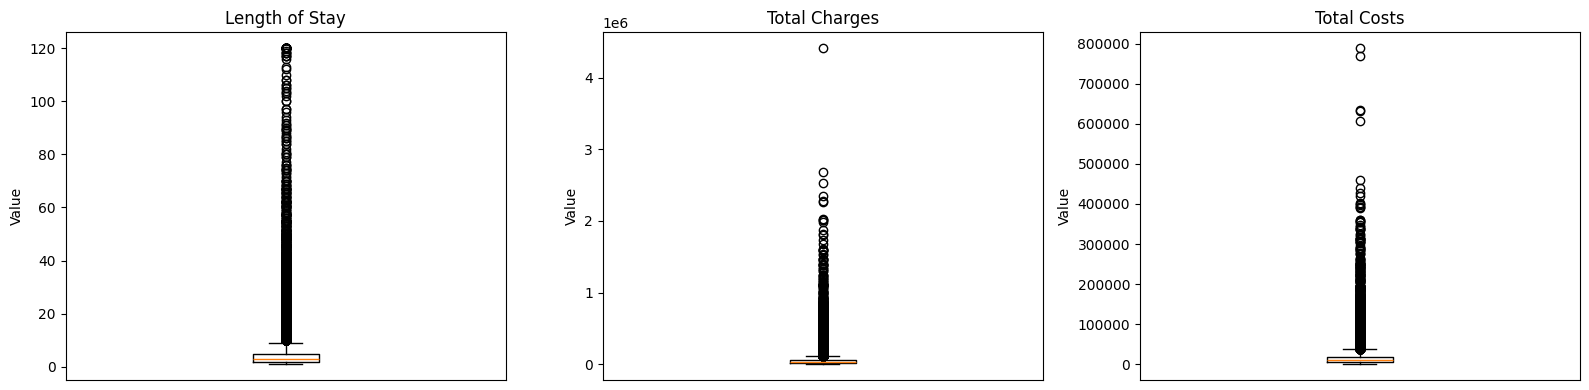

In [293]:
num_cols = ["Length of Stay", "Total Charges", "Total Costs"]

fig, axes = plt.subplots(1, len(num_cols), figsize=(16, 4))

for i, col in enumerate(num_cols):
    axes[i].boxplot(df[col].dropna())
    axes[i].set_title(col)
    axes[i].set_ylabel("Value")
    axes[i].set_xticks([])

plt.tight_layout()
plt.show()

- The dataset is lognormal - not normal in total charges and total costs
- LOS very skewed even after log transformation. Huge number of small stays. Small number of very long stays
- OUTLIERS ARE NOT ERROS. WE SHOULD NOT REMOVE THEM
- Mean does not show much. MEDIAN is more important


Right-skewness in all numerical variables, particularly in Total Charges and Total Costs, where extreme outliers are observed. These outliers represent high-cost cases and are normal to healthcare data  
Log transformation provides a clearer view of the underlying distributions, revealing that both cost-related variables follow an approximately log-normal distribution.  
Length of Stay remains skewed even after transformation, reflecting the clinical nature of hospital stays.

# New Section

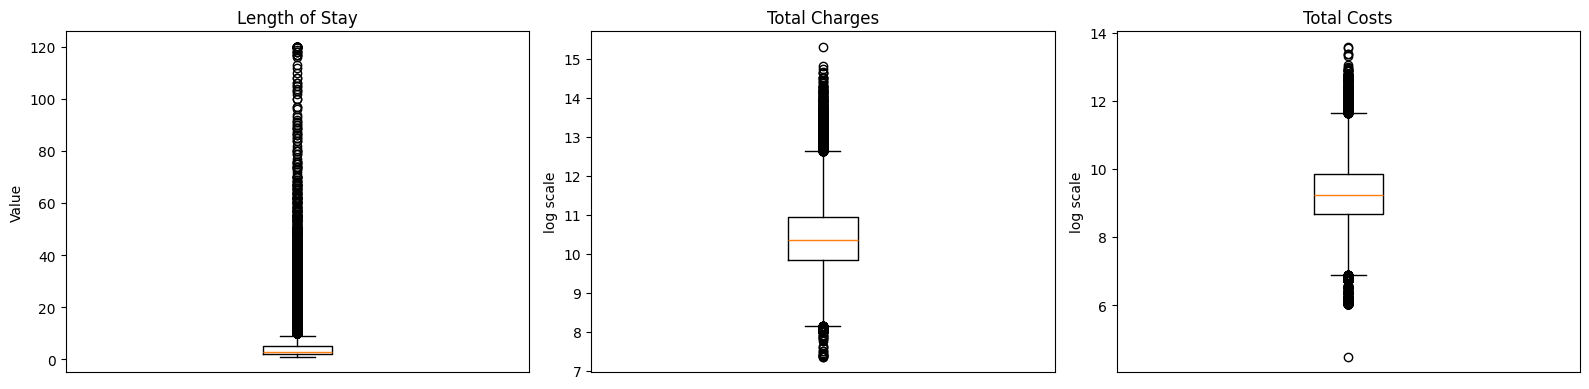

In [294]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

cols = ["Length of Stay", "Total Charges", "Total Costs"]

for i, col in enumerate(cols):
    x = df[col].dropna()

    if col != "Length of Stay":
        x = np.log1p(x)
        axes[i].set_ylabel("log scale")
    else:
        axes[i].set_ylabel("Value")

    axes[i].boxplot(x)
    axes[i].set_title(col)
    axes[i].set_xticks([])

plt.tight_layout()
plt.show()

# Understanding Variables - Univariate Analysis

## Numeric

In [265]:
# After conversion
numeric_cols = df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(exclude=['number']).columns

In [266]:
print("Numeric Columns:", numeric_cols)
print("Categorical Columns:", categorical_cols)

Numeric Columns: Index(['Length of Stay', 'Total Charges', 'Total Costs'], dtype='object')
Categorical Columns: Index(['Hospital County', 'Facility Name', 'Age Group', 'Gender', 'Race',
       'Ethnicity', 'Type of Admission', 'Patient Disposition',
       'APR DRG Description', 'APR Severity of Illness Description',
       'APR Risk of Mortality', 'Payment Typology 1',
       'Emergency Department Indicator'],
      dtype='object')


In [267]:
df[numeric_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Length of Stay,53376.0,4.982633,7.395185,1.00,2.0000,3.00,5.0000,120.00
Total Charges,53376.0,54361.518212,90230.004842,1560.00,18483.0150,30802.52,56712.9750,4409949.53
Total Costs,53376.0,16643.424635,23230.879414,88.27,5799.1675,10314.10,18997.5425,789031.39


In [268]:
# Summary statistics
summary = df[numeric_cols].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T
summary["skew"] = df[numeric_cols].skew(numeric_only=True)
summary

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max,skew
Length of Stay,53376.0,4.982633,7.395185,1.00,1.00,1.00,2.0000,3.00,5.0000,15.000,35.0000,120.00,7.500140
Total Charges,53376.0,54361.518212,90230.004842,1560.00,5103.96,6319.00,18483.0150,30802.52,56712.9750,172896.575,388461.3800,4409949.53,10.225547
Total Costs,53376.0,16643.424635,23230.879414,88.27,843.12,1012.82,5799.1675,10314.10,18997.5425,51509.540,106921.1525,789031.39,7.438960


**LOS**  
LOS is highly right-skewed, with a median of 3 days and a mean of 4.9 days. While most discharges occur within 5 days, a small number of cases extend to significantly longer durations, reflecting complex or severe conditions. Only 4% remain more than 15 days

**Total Charges**  
 exhibit a highly right-skewed distribution, with a median of approximately $30,774 and a mean of $53,541. A small proportion of cases accounts for extremely high charges, as indicated by the 99th percentile exceeding $379,000 and a maximum above $2.3 million.

 **Total Costs**  
 also demonstrate significant right-skewness, with a median of approximately $10,304 and a mean of $16,443. Similar to total charges, a small number of cases incur substantially higher costs.”

**Numeric Columns Distributions**

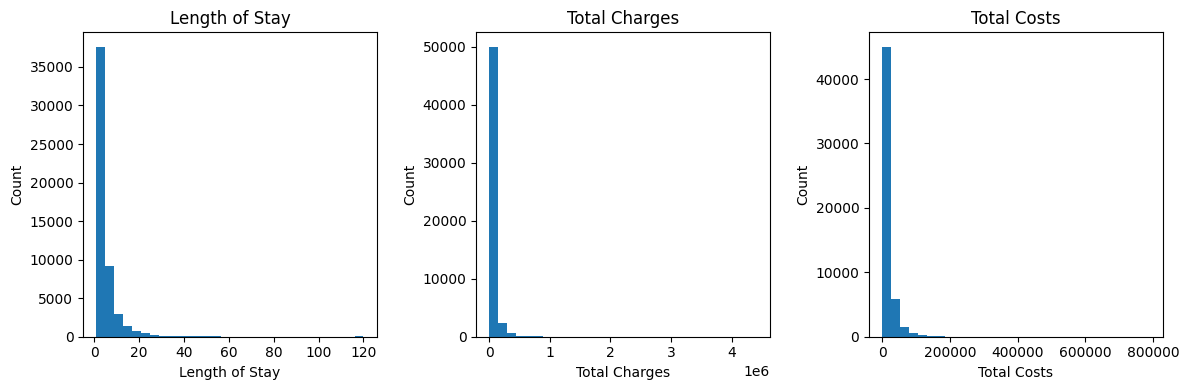

In [269]:
numeric_cols = list(df.select_dtypes(include="number").columns)

n = len(numeric_cols)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    axes[i].hist(df[col].dropna(), bins=30)
    axes[i].set_title(f"{col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

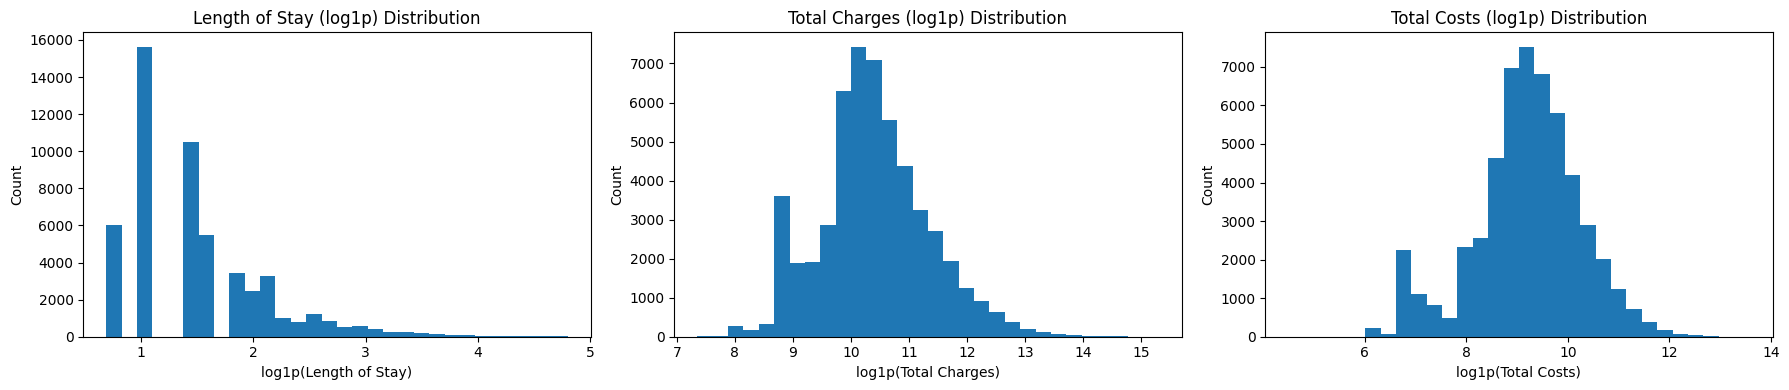

In [270]:
num_cols = ["Length of Stay", "Total Charges", "Total Costs"]
num_cols = [c for c in num_cols if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]

fig, axes = plt.subplots(1, len(num_cols), figsize=(6 * len(num_cols), 4))

# If only one numeric column, make axes iterable
if len(num_cols) == 1:
    axes = [axes]

for i, col in enumerate(num_cols):
    x = df[col].dropna()
    axes[i].hist(np.log1p(x), bins=30)
    axes[i].set_title(f"{col} (log1p) Distribution")
    axes[i].set_xlabel(f"log1p({col})")
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

“Log-transformed distributions of Length of Stay, Total Charges, and Total Costs show an almost norma shape.  **log-normal distributions**
**This suggests that extreme values observed in the raw data are not anomalies but characteristics of healthcare utilization, where a only a very small number of cases incur disproportionately high costs.”

Total Charges and Total costs seem to follow the same shape. **STRONG RELATIONSHIP**

## Categorical

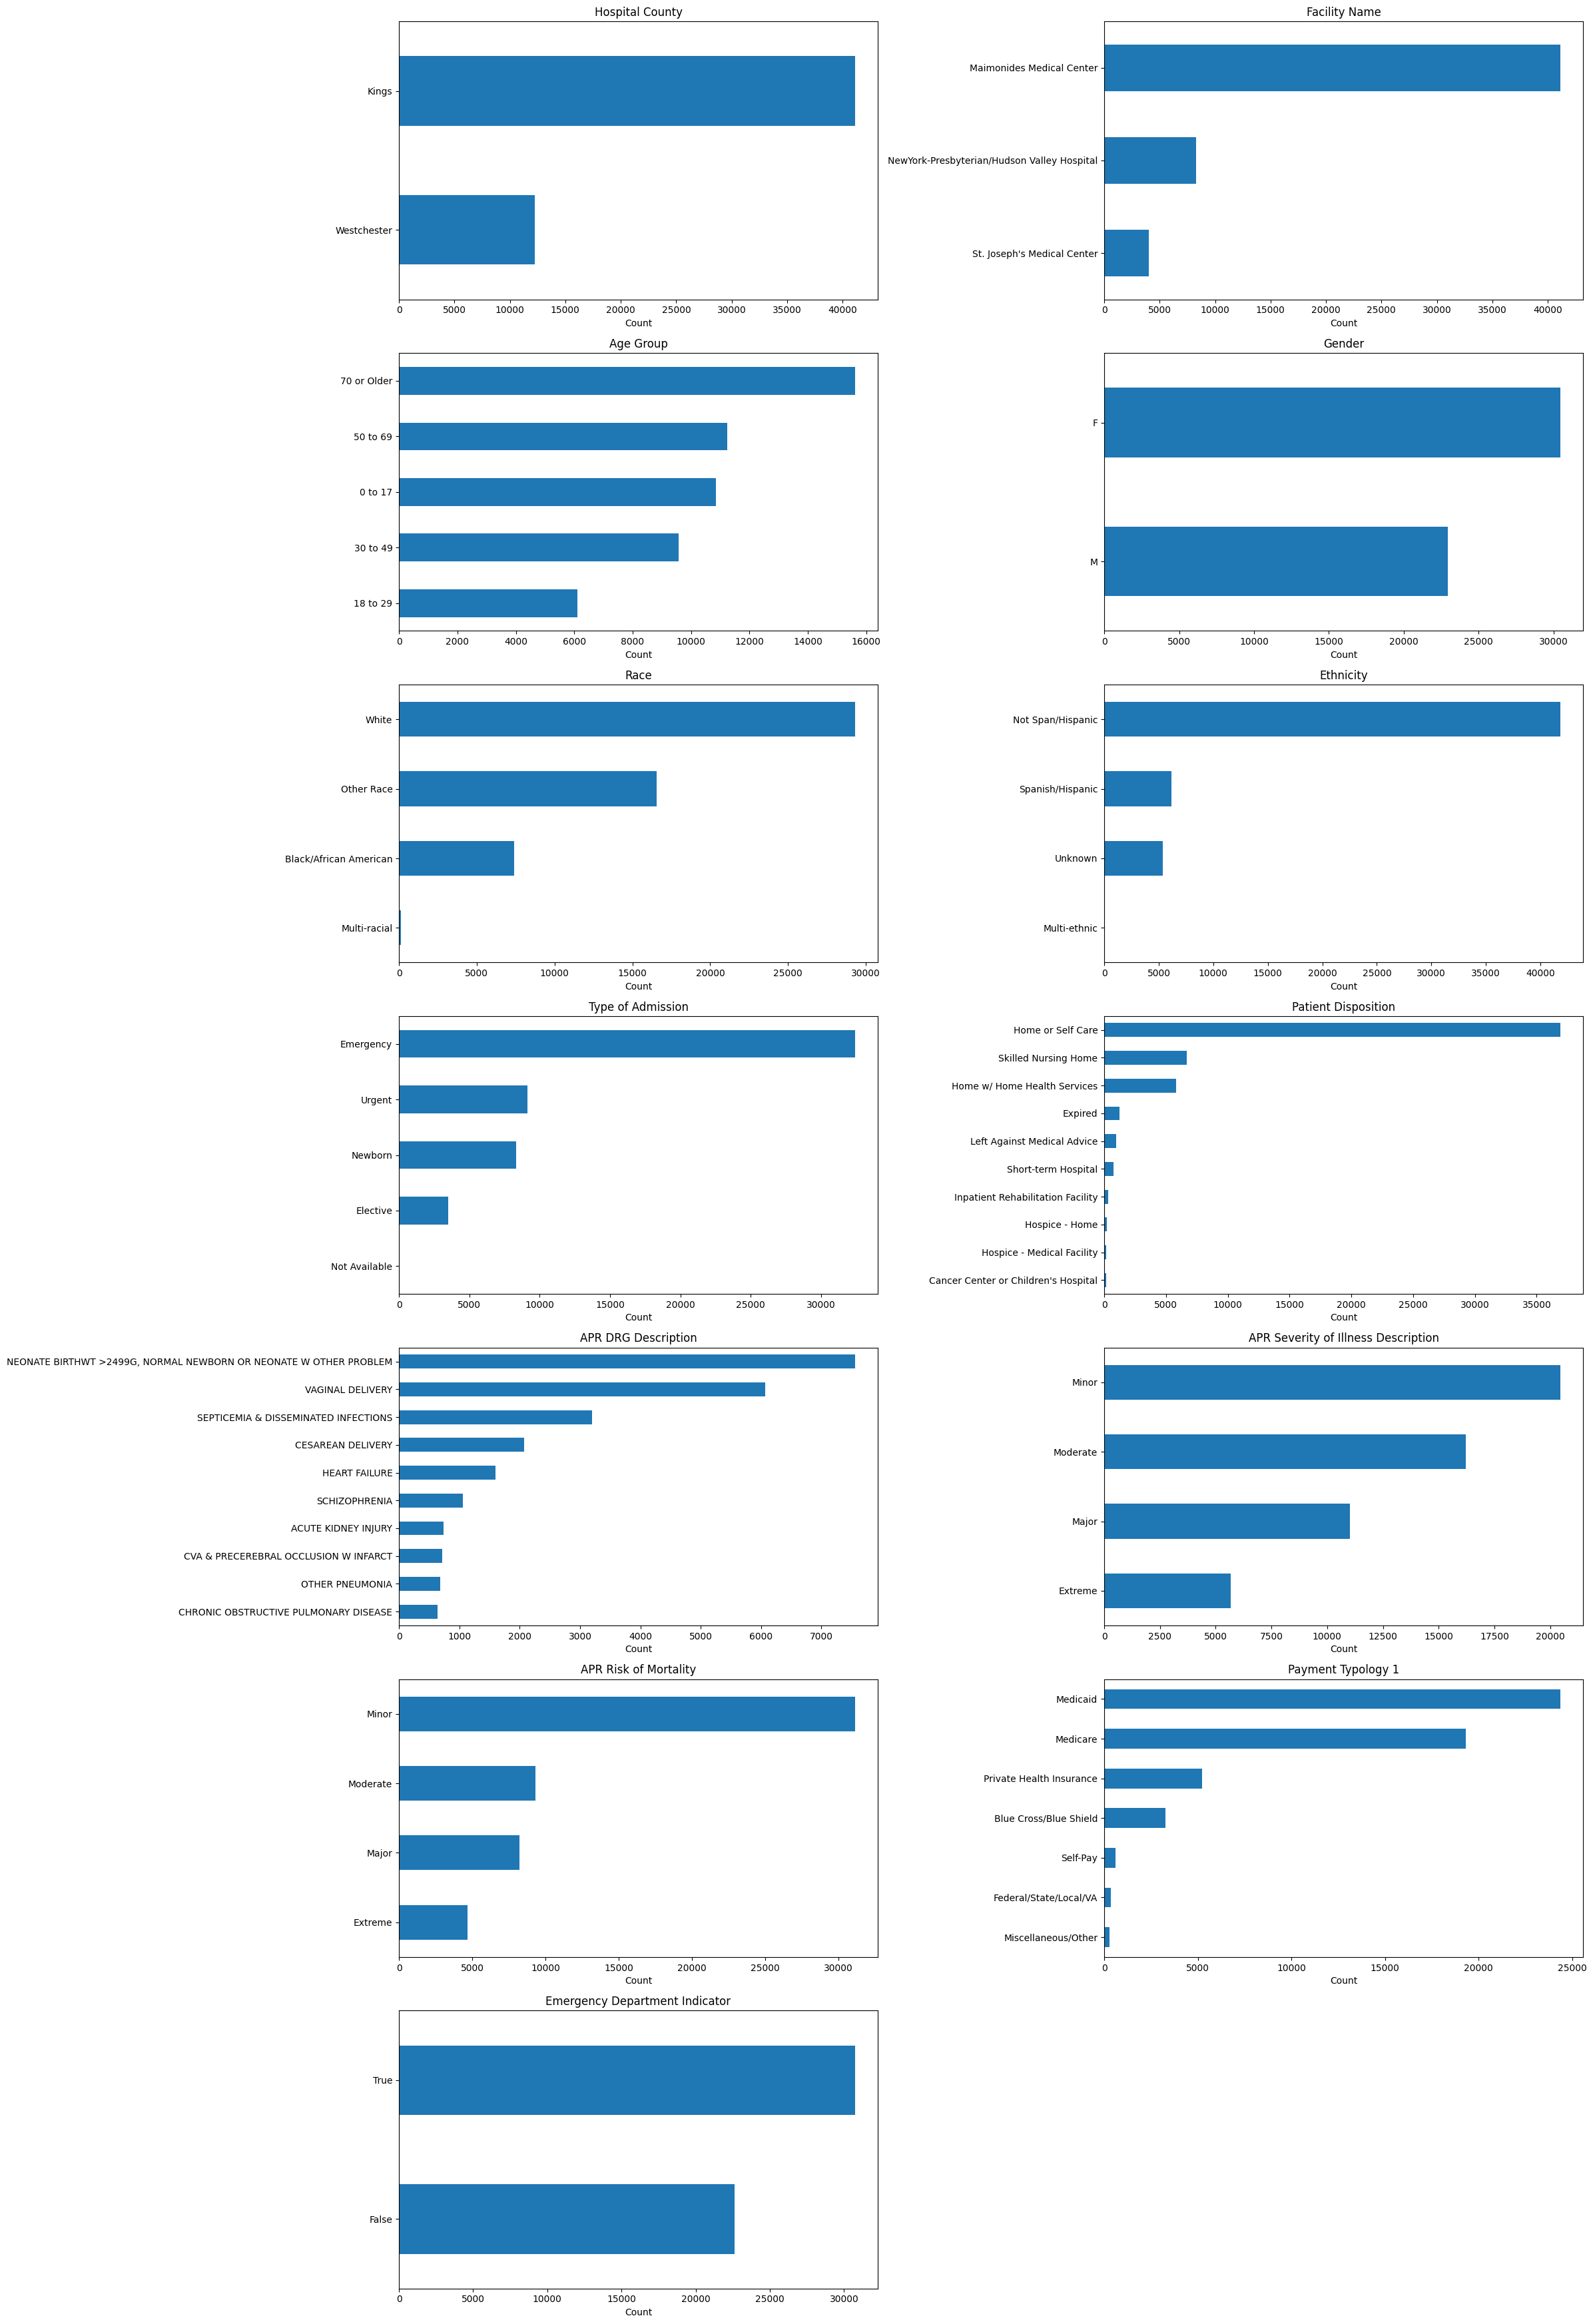

In [280]:
#Take the top 10 categories of each of the categorical values and show their distribution

cat_cols = [
    'Hospital County', 'Facility Name', 'Age Group', 'Gender', 'Race',
    'Ethnicity', 'Type of Admission', 'Patient Disposition',
    'APR DRG Description', 'APR Severity of Illness Description',
    'APR Risk of Mortality', 'Payment Typology 1',
    'Emergency Department Indicator'
]

# Layout
n = len(cat_cols)
cols = 2
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(24, 5 * rows))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    # Top 10 categories
    vc = df[col].value_counts().head(10).sort_values()

    vc.plot(kind='barh', ax=axes[i])

    axes[i].set_title(col)
    axes[i].set_xlabel("Count")
    axes[i].set_ylabel("")

# Remove empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

**Insights**
- Mamonidis dominates (Larger hospital results)
- Most people are of >70 years of age (skewed to older population)
- Women are more than men
- Emergency dominates massively (hospitals operate reactively)
- Most payments are by Medicaid and Medicare  (public Insurance Programs)
- Most admissions are for minor severity cases
- Not so big danger for mortality
- Most patients are discharged to go to Home or Selfcare (recovery with no long term needs)
- Emergency Department
- Most caes are fpr early birth. vaginal delivery and septicemia (accute infections)


# Understanding Variables - Bivariate Analysis

## **Correlation Matrix**

In [282]:
corr_matrix = df[["Length of Stay", "Total Charges", "Total Costs"]].corr()
#print(corr_matrix)

                Length of Stay  Total Charges  Total Costs
Length of Stay        1.000000       0.737860     0.765362
Total Charges         0.737860       1.000000     0.921704
Total Costs           0.765362       0.921704     1.000000


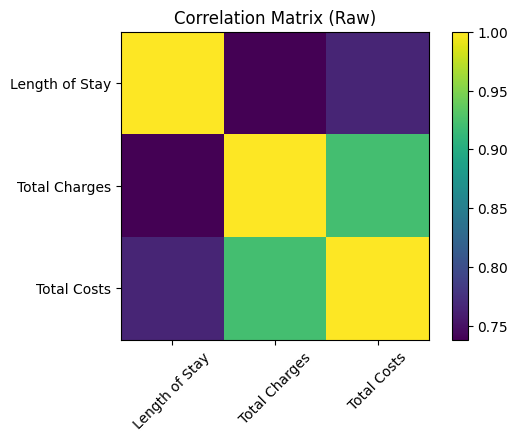

In [283]:
numeric_df = df[numeric_cols]
corr_matrix = numeric_df.corr(numeric_only=True)

plt.figure(figsize=(6,4))
plt.imshow(corr_matrix, cmap='viridis', interpolation='none')

plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

plt.title("Correlation Matrix (Raw)")
plt.show()

In [284]:
#To outsmart the skewness of the raw data
log_df = np.log1p(df[["Length of Stay", "Total Charges", "Total Costs"]])
log_corr = log_df.corr()

print(log_corr)

                Length of Stay  Total Charges  Total Costs
Length of Stay        1.000000       0.680098     0.667123
Total Charges         0.680098       1.000000     0.916937
Total Costs           0.667123       0.916937     1.000000


***strong relationships**
 - Total Charges and Total Costs, indicating that both variables are closely aligned.
 - Length of Stay exhibits a moderate positive correlation with both cost measures, suggesting that longer hospital stays are associated with increased financial burden
 - with the log version we only make the differences more eminent, especially with the not so strong correlations of LOS with total charges and total costs

## Scatter plots

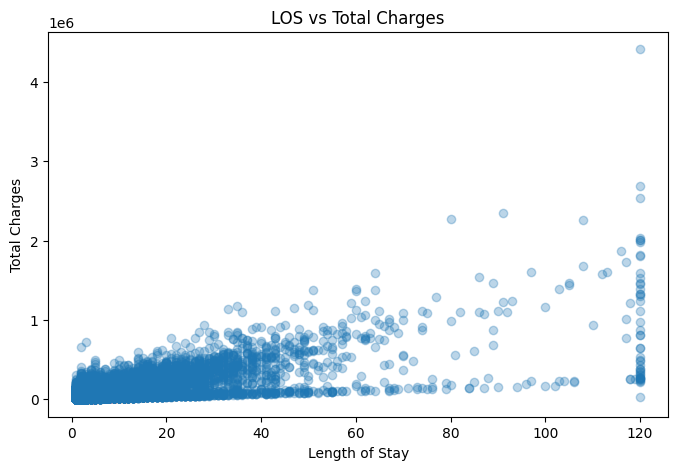

In [290]:
plt.figure(figsize=(8,5))
plt.scatter(df["Length of Stay"], df["Total Charges"], alpha=0.3)

plt.xlabel("Length of Stay")
plt.ylabel("Total Charges")
plt.title("LOS vs Total Charges")

plt.show()

***Insight**
Longer stay, larger charges.
But this is not the only driver for Charges (i.e severity, type of illness, procedure)
120 CAP is due to 120+ in the dataset


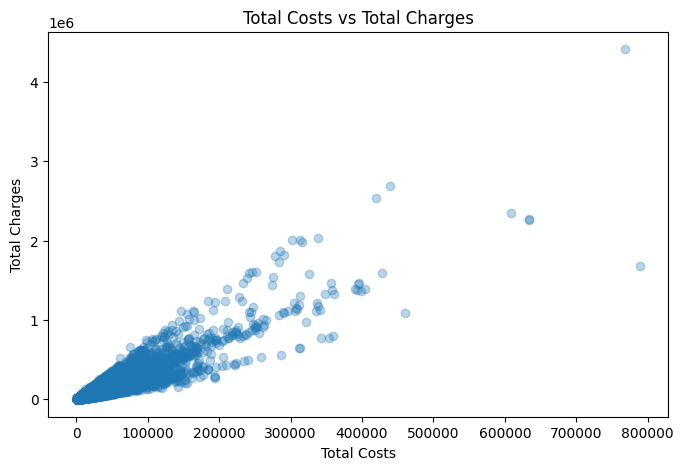

In [295]:
plt.figure(figsize=(8,5))
plt.scatter(df["Total Costs"], df["Total Charges"], alpha=0.3)

plt.xlabel("Total Costs")
plt.ylabel("Total Charges")
plt.title("Total Costs vs Total Charges")

plt.show()

**Insight**
A strong linear relationship is observed between Total Costs and Total Charges, indicating that hospital charges are closely aligned with underlying cost
cost = what is estimated
charged = what is invoiced

| Relationship     | Strength       | Meaning               |
| ---------------- | -------------- | --------------------- |
| Costs vs Charges | Very strong | Direct financial link |
| LOS vs Charges   | Moderate    | Operational driver    |


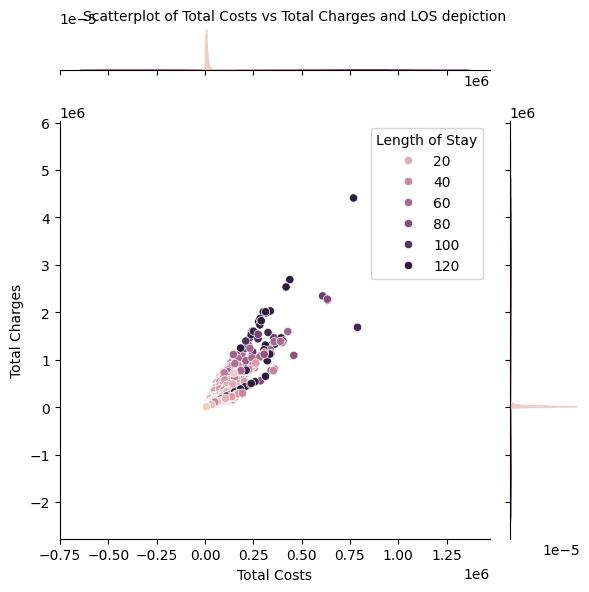

In [299]:
# Create jointplot
jp = sns.jointplot(
    x='Total Costs',
    y='Total Charges',
    hue='Length of Stay',
    data=df,
    height=6,   # controls figure size
)

# Set title on the figure
jp.fig.suptitle('Scatterplot of Total Costs vs Total Charges and LOS depiction', fontsize=10) #, fontweight='bold')

# Adjust spacing so title doesn't overlap
jp.fig.tight_layout()
jp.fig.subplots_adjust(top=0.95)  # move title up

# Feature Engineering

Cost and charge per LOS

In [300]:
df["Charge per Day"] = df["Total Charges"] / df["Length of Stay"]
df["Cost per Day"] = df["Total Costs"] / df["Length of Stay"]

Average LOS per hospital

In [301]:
df.groupby("Facility Name")["Length of Stay"].mean()

,Length of Stay
Facility Name,
Maimonides Medical Center,4.948852
NewYork-Presbyterian/Hudson Valley Hospital,3.951435
St. Joseph's Medical Center,7.456658


Average cost per hospital

In [304]:
df.groupby("Facility Name")["Total Charges"].mean()

,Total Charges
Facility Name,
Maimonides Medical Center,58288.610034
NewYork-Presbyterian/Hudson Valley Hospital,47390.551003
St. Joseph's Medical Center,28404.228404


Average Cost by Severity

In [308]:
order = ["Minor", "Moderate", "Major", "Extreme"]

result = df.groupby("APR Severity of Illness Description")["Total Charges"].mean()

result = result.reindex(order)

result

,Total Charges
APR Severity of Illness Description,
Minor,27131.500288
Moderate,43599.035105
Major,67109.127401
Extreme,158436.676381


Emergency Rage

In [306]:
df["Emergency Department Indicator"].value_counts(normalize=True)

,proportion
Emergency Department Indicator,
True,0.575802
False,0.424198


# Extract final file

In [309]:
#save file to csv
df.to_csv("final_hospital_discharges.csv", index=False)

In [310]:
df.head()

,Hospital County,Facility Name,Age Group,Gender,Race,Ethnicity,Length of Stay,Type of Admission,Patient Disposition,APR DRG Description,APR Severity of Illness Description,APR Risk of Mortality,Payment Typology 1,Emergency Department Indicator,Total Charges,Total Costs,Charge per Day,Cost per Day
0,Kings,Maimonides Medical Center,50 to 69,F,Other Race,Not Span/Hispanic,21,Urgent,Skilled Nursing Home,CARDIAC VALVE PROCEDURES W AMI OR COMPLEX PDX,Extreme,Extreme,Medicaid,False,401807.05,100294.11,19133.669048,4775.910000
1,Kings,Maimonides Medical Center,0 to 17,F,Black/African American,Not Span/Hispanic,3,Emergency,Home or Self Care,ASTHMA,Major,Moderate,Medicaid,True,46725.01,23058.16,15575.003333,7686.053333
2,Kings,Maimonides Medical Center,0 to 17,F,White,Unknown,1,Newborn,Home or Self Care,"NEONATE BIRTHWT >2499G, NORMAL NEWBORN OR NEON...",Minor,Minor,Medicaid,False,3393.00,490.45,3393.000000,490.450000
3,Kings,Maimonides Medical Center,18 to 29,F,White,Unknown,2,Urgent,Home or Self Care,VAGINAL DELIVERY,Minor,Minor,Medicaid,True,20858.02,5445.28,10429.010000,2722.640000
4,Kings,Maimonides Medical Center,18 to 29,F,White,Not Span/Hispanic,2,Urgent,Home or Self Care,VAGINAL DELIVERY,Minor,Minor,Medicaid,False,21116.01,5295.36,10558.005000,2647.680000


In [312]:
df.shape

(53376, 18)

# Suggestions from GPT on how to build the dashboards

🎯 OVERALL STORY (VERY IMPORTANT)

Your dashboards should answer this narrative:

“Hospital costs are driven by Length of Stay, Severity, and case complexity, with strong variability across hospitals and patient types.”

🟦 1. C-LEVEL DASHBOARD (EXECUTIVE VIEW)
🎯 Purpose

👉 High-level overview
👉 Focus on KPIs & decisions

🔥 Key Questions

How expensive are we?

What drives costs?

Which hospital performs best/worst?

📊 KPIs (top row)

Median Total Charges

Median Length of Stay

Median Cost per Day

% Emergency Admissions

📈 Visuals
1. Charges by Hospital

👉 Bar chart

X: Facility Name

Y: Median Total Charges

2. Cost Driver (VERY IMPORTANT)

👉 Scatter or KPI card

LOS vs Charges (summary insight)

3. Severity Impact

👉 Bar chart

X: Severity

Y: Median Charges

4. Payment Mix

👉 Donut chart

Medicaid / Medicare / Private

🎯 Insight to show

“Costs increase with severity and LOS, with strong dependence on public funding.”

🟩 2. DIRECTOR DASHBOARD (OPERATIONAL VIEW)
🎯 Purpose

👉 Hospital performance
👉 Operational efficiency

🔥 Key Questions

Which hospital is more efficient?

Where are we losing money?

What drives LOS?

📊 KPIs

Median LOS per hospital

Median Cost per hospital

Admissions by type

📈 Visuals
1. Hospital Comparison (CRITICAL)

👉 Bar chart

Facility vs Median LOS

Facility vs Median Charges

2. Admission Type

👉 Stacked bar

Emergency / Elective / Urgent

3. Patient Flow

👉 Patient Disposition

Home / Nursing / etc.

4. LOS Distribution

👉 Boxplot or histogram (Power BI)

5. Severity Mix

👉 Stacked chart

Severity by hospital

🎯 Insight to show

“Hospitals differ in LOS and cost efficiency, with emergency admissions dominating operations.”

🟨 3. TECHNICAL DASHBOARD (ANALYTICAL VIEW)
🎯 Purpose

👉 Deep data understanding
👉 Support analysis decisions

🔥 Key Questions

What do distributions look like?

How strong are relationships?

Where are outliers?

📊 Visuals
1. Histograms

LOS

Charges

Costs

2. Boxplots

LOS

Charges

Costs

3. Scatter Plots (VERY IMPORTANT)

👉 LOS vs Charges
👉 Costs vs Charges

4. Correlation Matrix (optional but strong)
5. DRG Analysis

👉 Top diagnoses

🎯 Insight to show

“Data is highly skewed with significant outliers and strong relationships between cost variables.”

🧠 HOW THEY CONNECT (STORY FLOW)
🔵 C-Level

👉 “Costs are high”

↓

🟢 Director

👉 “Driven by LOS, severity, hospital differences”

↓

🟡 Technical

👉 “Here is the detailed statistical evidence”

🎯 KEY KPIs YOU MUST CREATE

In Power BI:

Median Charges

Median LOS

Cost per Day

% Emergency

Charges by Severity

Charges by Hospital

🚀 FINAL STRUCTURE (VERY IMPORTANT)
Dashboard 1: Executive Summary

👉 Simple, clean, KPI-focused

Dashboard 2: Operations

👉 Comparison & breakdown

Dashboard 3: Deep Analysis

👉 Distributions + relationships

🎯 FINAL TIP (VERY IMPORTANT)

👉 DO NOT overload dashboards
👉 Each must answer specific questions